# App example usage

In [20]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [21]:
# Load the saved model
with open("../models/xgboost_model.pkl", "rb") as file:
    model = pickle.load(file)

# Konfiguracja skryptu
date = "2024-12-16"  # Data prognozy


In [22]:
# Generowanie danych prognozowych
def generate_forecast_data(date):
    hours = list(range(24))  # Jednogodzinne interwały
    is_holiday = 0  # Poniedziałek nie jest świętem
    is_weekend = 0  # Poniedziałek nie jest weekendem
    season = 3  # Zima
    weather_code = 4  # Pochmurnie
    temperatures = np.linspace(8, 12, 24)  # Temperatura od 8 do 12 stopni
    feels_like = temperatures - 0.5  # Temperatura odczuwalna nieco niższa
    humidity = np.random.uniform(80, 90, 24)  # Wilgotność 80-90%
    wind_speed = np.random.uniform(12, 14, 24)  # Prędkość wiatru 12-14 km/h

    # Budowanie DataFrame
    forecast_df = pd.DataFrame({
        "t1": temperatures,
        "t2": feels_like,
        "hum": humidity,
        "wind_speed": wind_speed,
        "weather_code": [weather_code] * 24,
        "is_holiday": [is_holiday] * 24,
        "is_weekend": [is_weekend] * 24,
        "season": [season] * 24,
        "month": [12] * 24,
        "day": [16] * 24,
        "weekday": [0] * 24,  # Poniedziałek
        "hour": hours
    })
    return forecast_df

# Generowanie danych dla 16.12.2024
forecast_data = generate_forecast_data(date)
forecast_data.head()


,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,month,day,weekday,hour
0,8.000000,7.500000,88.617556,13.873863,4,0,0,3,12,16,0,0
1,8.173913,7.673913,81.379000,13.555238,4,0,0,3,12,16,0,1
2,8.347826,7.847826,84.219344,12.544505,4,0,0,3,12,16,0,2
3,8.521739,8.021739,87.423308,13.577050,4,0,0,3,12,16,0,3
4,8.695652,8.195652,83.784719,13.984693,4,0,0,3,12,16,0,4


In [28]:
import numpy as np
import pandas as pd

# Generowanie danych prognozowych
def generate_forecast_data(date):
    hours = list(range(24))  # Jednogodzinne interwały
    is_holiday = 0  # Poniedziałek nie jest świętem
    is_weekend = 0  # Poniedziałek nie jest weekendem
    season = 3  # Zima
    weather_code = [7 if hour < 5 else 3 if hour < 18 else 4 for hour in hours]  # Pogoda zależna od godziny
    temperatures = np.linspace(14, 15, 24)  # Temperatury od 14 do 15 stopni
    feels_like = temperatures  # Dla uproszczenia "feels like" równe rzeczywistej temperaturze
    humidity = [88 if hour < 6 else 82 if hour < 18 else 85 for hour in hours]  # Wilgotność zależna od godziny
    wind_speed = [17 if hour < 6 else 25 if hour < 18 else 18 for hour in hours]  # Prędkość wiatru zależna od godziny

    # Budowanie DataFrame
    forecast_df = pd.DataFrame({
        "t1": temperatures,
        "t2": feels_like,
        "hum": humidity,
        "wind_speed": wind_speed,
        "weather_code": weather_code,
        "is_holiday": [is_holiday] * 24,
        "is_weekend": [is_weekend] * 24,
        "season": [season] * 24,
        "month": [12] * 24,
        "day": [16] * 24,
        "weekday": [pd.Timestamp(date).weekday()] * 24,  # Automatyczne wyznaczenie dnia tygodnia
        "hour": hours
    })
    return forecast_df

# Generowanie danych dla 16.12.2024
date = "2015-12-16"
forecast_data = generate_forecast_data(date)
forecast_data.head(24)


,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,month,day,weekday,hour
0,14.000000,14.000000,88,17,7,0,0,3,12,16,2,0
1,14.043478,14.043478,88,17,7,0,0,3,12,16,2,1
2,14.086957,14.086957,88,17,7,0,0,3,12,16,2,2
3,14.130435,14.130435,88,17,7,0,0,3,12,16,2,3
4,14.173913,14.173913,88,17,7,0,0,3,12,16,2,4
5,14.217391,14.217391,88,17,3,0,0,3,12,16,2,5
6,14.260870,14.260870,82,25,3,0,0,3,12,16,2,6
7,14.304348,14.304348,82,25,3,0,0,3,12,16,2,7
8,14.347826,14.347826,82,25,3,0,0,3,12,16,2,8
9,14.391304,14.391304,82,25,3,0,0,3,12,16,2,9


In [29]:
# Load the scaler from a file
scaler_path = "../models/scaler.pkl"
with open(scaler_path, "rb") as file:
    scaler = pickle.load(file)

# Normalizacja danych
features = forecast_data.columns
forecast_data_normalized = forecast_data.copy()
forecast_data_normalized[features] = scaler.transform(forecast_data[features])

In [31]:
# Prognozowanie liczby wypożyczeń
forecast_data["predicted_cnt"] = model.predict(forecast_data_normalized[features])

# Wyświetlenie prognoz
forecast_data[["predicted_cnt"]].head(24)


,predicted_cnt
0,591.908691
1,2054.319580
2,710.920593
3,710.920593
4,710.920593
5,708.511841
6,708.511841
7,708.511841
8,708.511841
9,708.511841


In [32]:
print(forecast_data.tail(10))  # Ostatnie godziny dnia

           t1         t2  hum  wind_speed  weather_code  is_holiday  \
14  14.608696  14.608696   82          25             3           0   
15  14.652174  14.652174   82          25             3           0   
16  14.695652  14.695652   82          25             3           0   
17  14.739130  14.739130   82          25             3           0   
18  14.782609  14.782609   85          18             4           0   
19  14.826087  14.826087   85          18             4           0   
20  14.869565  14.869565   85          18             4           0   
21  14.913043  14.913043   85          18             4           0   
22  14.956522  14.956522   85          18             4           0   
23  15.000000  15.000000   85          18             4           0   

    is_weekend  season  month  day  weekday  hour  predicted_cnt  
14           0       3     12   16        2    14     708.511841  
15           0       3     12   16        2    15     708.511841  
16           0   

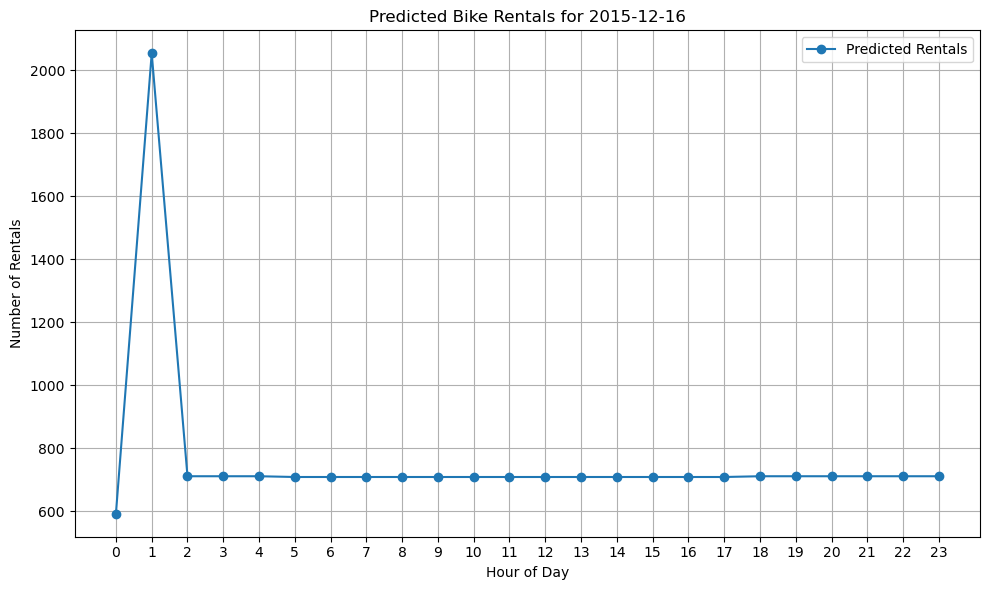

In [33]:
# Wizualizacja prognoz
plt.figure(figsize=(10, 6))
plt.plot(forecast_data["hour"], forecast_data["predicted_cnt"], marker="o", label="Predicted Rentals")
plt.title(f"Predicted Bike Rentals for {date}")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Rentals")
plt.xticks(range(24))
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
